# Import Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import yfinance as yf

# Fetch Historical Data


In [ ]:
# Function to fetch stock data (with Open and Close prices)
def fetch_stock_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)
    return data[['Open', 'Adj Close']]

# Fetch historical data for analysis
start_analysis = '2020-01-01'
end_analysis = '2024-05-01'

stock_1 = fetch_stock_data('TASA3.SA', start_analysis, end_analysis)
stock_2 = fetch_stock_data('TASA4.SA', start_analysis, end_analysis)

# Create a dataframe with both stocks
df_analysis = pd.DataFrame({'TASA3_Open': stock_1['Open'], 'TASA3_Close': stock_1['Adj Close'],
                            'TASA4_Open': stock_2['Open'], 'TASA4_Close': stock_2['Adj Close']}).dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


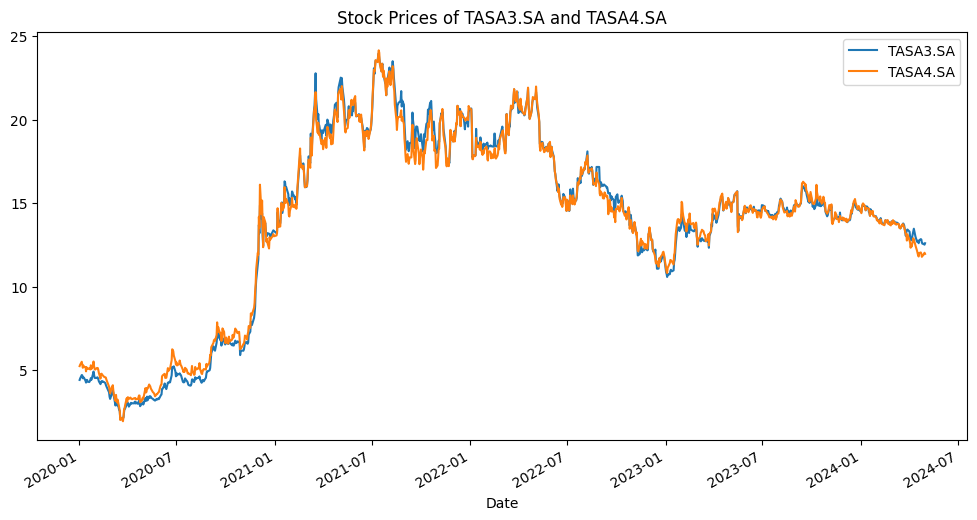

In [ ]:
# Plot the stock prices
df_analysis[['TASA3_Close','TASA4_Close']].rename(columns={'TASA3_Close': 'TASA3.SA', 'TASA4_Close': 'TASA4.SA'}).plot(figsize=(12, 6))
plt.title('Stock Prices of TASA3.SA and TASA4.SA')
plt.show()

# Test for Cointegration

In [ ]:
score, p_value, _ = coint(df_analysis['TASA3_Close'], df_analysis['TASA4_Close'])
print(f'Cointegration test p-value: {p_value}')

Cointegration test p-value: 0.000545099835442837


<ipython-input-5-9c7e2ce23a21>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_analysis['Spread'] = df_analysis['TASA3_Close'] - model.params[1] * df_analysis['TASA4_Close']


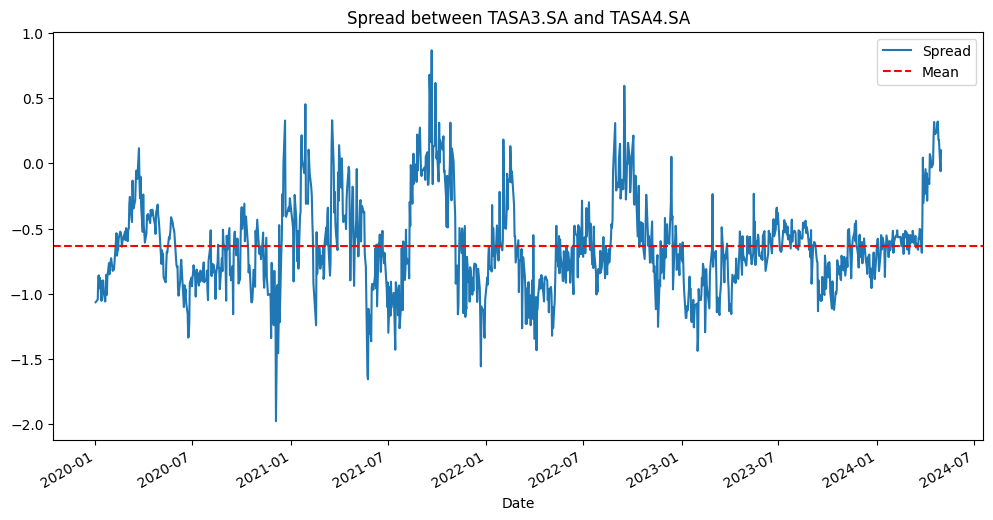

In [ ]:
# Perform linear regression to estimate the relationship
X_analysis = sm.add_constant(df_analysis['TASA4_Close'])
model = sm.OLS(df_analysis['TASA3_Close'], X_analysis).fit()

# Calculate the spread
df_analysis['Spread'] = df_analysis['TASA3_Close'] - model.params[1] * df_analysis['TASA4_Close']

# Plot the spread
plt.figure(figsize=(12, 6))
df_analysis['Spread'].plot()
plt.axhline(df_analysis['Spread'].mean(), color='red', linestyle='--', label='Mean')
plt.title('Spread between TASA3.SA and TASA4.SA')
plt.legend()
plt.show()

In [ ]:
# Summary statistics of the spread
mean_spread = df_analysis['Spread'].mean()
std_spread = df_analysis['Spread'].std()

print(f"Mean Spread: {mean_spread}, Std Spread: {std_spread}")

Mean Spread: -0.6326797611295375, Std Spread: 0.35470481211680366


# Fetch Test Data

In [ ]:
# Fetch data for testing the strategy
start_strategy = '2024-05-01'
end_strategy = '2024-07-01'

stock_1_test = fetch_stock_data('TASA3.SA', start_strategy, end_strategy)
stock_2_test = fetch_stock_data('TASA4.SA', start_strategy, end_strategy)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-8-ddcfd00375b1>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_test['Spread'] = df_test['TASA3_Close'] - model.params[1] * df_test['TASA4_Close']


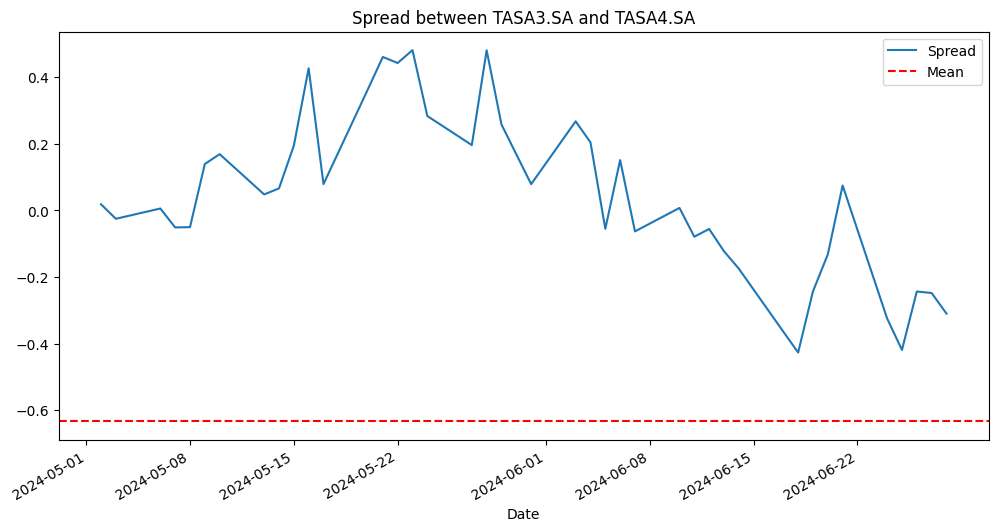

In [ ]:
# Create a dataframe with both stocks for the test period
df_test = pd.DataFrame({'TASA3_Open': stock_1_test['Open'], 'TASA3_Close': stock_1_test['Adj Close'],
                        'TASA4_Open': stock_2_test['Open'], 'TASA4_Close': stock_2_test['Adj Close']}).dropna()

# Calculate the spread using the model
df_test['Spread'] = df_test['TASA3_Close'] - model.params[1] * df_test['TASA4_Close']

# Plot the spread for the test period
plt.figure(figsize=(12, 6))
df_test['Spread'].plot()
plt.axhline(mean_spread, color='red', linestyle='--', label='Mean')
plt.title('Spread between TASA3.SA and TASA4.SA')
plt.legend()
plt.show()

# Implement the Strategy


In [ ]:
# Function to apply short selling cost and taxes
def apply_costs_and_taxes(df, short_fee=0.10):
    daily_short_fee = (1 + short_fee) ** (1 / 252) - 1  # Adjust annual fee to daily
    df['TASA3_Return'] = (df['TASA3_Close'] - df['TASA3_Open']) / df['TASA3_Open']
    df['TASA4_Return'] = (df['TASA4_Close'] - df['TASA4_Open']) / df['TASA4_Open']

    # Calculate strategy return: Buy TASA3 and sell TASA4 (or vice versa)
    df['Strategy_Return'] = df['Position'] * (df['TASA3_Return'] - df['TASA4_Return'])

    # Apply short selling cost (TASA3 short or TASA4 short)
    df.loc[df['Position'] != 0, 'Strategy_Return'] -= daily_short_fee

    # Apply 20% tax on profits for both long and short positions
    df['Strategy_Return_After_Tax'] = np.where(df['Strategy_Return'] > 0,
                                               df['Strategy_Return'] * 0.80,  # 20% tax on profit
                                               df['Strategy_Return'])         # No tax on loss

    return df

In [ ]:
# Define thresholds for trading based on the analysis (1 std deviation from the mean)
df_test['Buy_Signal'] = df_test['Spread'] < (mean_spread - std_spread)
df_test['Sell_Signal'] = df_test['Spread'] > (mean_spread + std_spread)

# Implement the strategy
df_test['Position'] = 0  # +1 means long TASA3, short TASA4; -1 means short TASA3, long TASA4
df_test['Position'] = np.where(df_test['Buy_Signal'], 1, np.where(df_test['Sell_Signal'], -1, 0))

# Shift position for the next day
df_test['Position'] = df_test['Position'].shift()

# Apply the strategy costs and taxes
df_test = apply_costs_and_taxes(df_test)

# Cumulative returns over time (Strategy with taxes)
df_test['Cumulative_Strategy_Return'] = (1 + df_test['Strategy_Return_After_Tax']).cumprod()

# Calculate cumulative returns for TASA3 and TASA4 in base 1 (starting from 1)
df_test['Cumulative_TASA3'] = (df_test['TASA3_Close'] / df_test['TASA3_Open'].iloc[0])
df_test['Cumulative_TASA4'] = (df_test['TASA4_Close'] / df_test['TASA4_Open'].iloc[0])

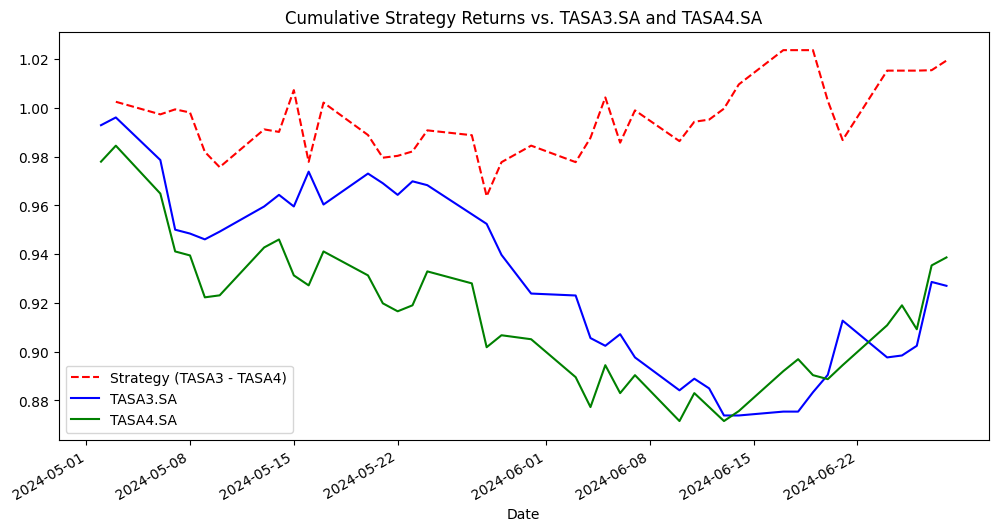

In [ ]:
# Plot cumulative returns (Strategy vs. TASA3.SA vs. TASA4.SA)
plt.figure(figsize=(12, 6))
df_test['Cumulative_Strategy_Return'].plot(label='Strategy (TASA3 - TASA4)', linestyle='--', color='red')
df_test['Cumulative_TASA3'].plot(label='TASA3.SA', linestyle='-', color='blue')
df_test['Cumulative_TASA4'].plot(label='TASA4.SA', linestyle='-', color='green')
plt.title('Cumulative Strategy Returns vs. TASA3.SA and TASA4.SA')
plt.legend()
plt.show()

# Summary

In [ ]:
# Summary of the trading strategy results
final_return = df_test['Cumulative_Strategy_Return'].iloc[-1] - 1
print(f'Total return from the strategy: {final_return:.2%}')

Total return from the strategy: 1.94%
